In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam
from VariationalBayes.NormalParams import MVNParam, UVNParam
from VariationalBayes.GammaParams import GammaParam

# import math

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize


In [2]:
# This should go in the main library.
from VariationalBayes.Parameters import set_free_offset, get_free_offset

class UVNParamVector(object):
    def __init__(self, name, length, min_var=0.0):
        self.name = name
        self.mean = VectorParam(name + '_mean', length)
        self.var = VectorParam(name + '_var', length, lb=min_var)
        self.__free_size = self.mean.free_size() + self.var.free_size()
    def __str__(self):
        return self.name + ':\n' + str(self.mean) + '\n' + str(self.var)
    def names(self):
        return self.mean.names() + self.var.names()
    def e(self):
        return self.mean.get()
    def e_outer(self):
        mean = self.mean.get() ** 2 + self.var.get()
    def set_free(self, free_val):
        if free_val.size != self.__free_size: \
            raise ValueError('Wrong size for UVNParam ' + self.name)
        offset = 0
        offset = set_free_offset(self.mean, free_val, offset)
        offset = set_free_offset(self.var, free_val, offset)
    def get_free(self):
        vec = np.empty(self.__free_size)
        offset = 0
        offset = get_free_offset(self.mean, vec, offset)
        offset = get_free_offset(self.var, vec, offset)
        return vec
    def free_size(self):
        return self.__free_size

In [43]:
N = 20     # observations per group
K = 25      # dimension of regressors
NG = 500      # number of groups

# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict()

glmm_par.push_param(UVNParam('mu'))
glmm_par.push_param(GammaParam('tau'))
glmm_par.push_param(MVNParam('beta', K))
glmm_par.push_param(UVNParamVector('u', NG))

glmm_par['mu'].mean.set(0.1)
glmm_par['mu'].var.set(1.0)

glmm_par['tau'].shape.set(2.1)
glmm_par['tau'].rate.set(2.1)

glmm_par['beta'].mean.set(np.full(K, 0.))
glmm_par['beta'].cov.set(0.2 * np.eye(K))

glmm_par['u'].mean.set(np.full(NG, 0.))
glmm_par['u'].var.set(np.full(NG, 0.1))
    
print N * NG
print glmm_par

10000
ModelParamsList:
	mu:
mu_mean: 0.1
mu_var: 1.0
	tau:
tau_shape: 2.1
tau_rate: 2.1
	beta:
beta_mean:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
beta_cov:
[[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  

In [44]:
# Generate data

def Logistic(u):
    return np.exp(u) / (1 + np.exp(u))

NObs = NG * N
true_beta = np.random.rand(K) - 0.5
true_mu = 0.2
true_tau = 4.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_tau), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = [ g for g in range(NG) for n in range(N) ]
true_rho = Logistic(np.matmul(x_mat, true_beta) + true_u[y_g_vec])
y_vec = np.random.random(NObs) < true_rho


In [45]:
def DataLogLikelihood(x_mat, y_vec, e_beta, e_beta_outer, e_u, var_u, std_draws):
    rho_mean = e_u + np.matmul(x_mat, e_beta)
    rho_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, e_beta_outer, x_mat))
    z = np.einsum('i,j->ij', rho_sd, std_draws) + np.expand_dims(rho_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # log(1 - p) = log(1 / (1 + exp(u))) = -log(1 + exp(u))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * rho_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum((e_mu - e_u) ** 2 + var_mu + var_u) + \
           0.5 * e_log_tau * len(e_u)

def UnivariateNormalEntropy(var_obs):
    return 0.5 * np.sum(np.log(var_obs))

def MultivariateNormalEntropy(cov_obs):
    sign, logdet = np.linalg.slogdet(cov_obs)
    assert sign > 0
    return 0.5 * logdet

def GammaEntropy(shape, rate):
    return np.sum(shape - np.log(rate) + asp.special.gammaln(shape) + \
                  (1 - shape) * asp.special.digamma(shape))

def MVNPrior(prior_mean, prior_info, e_obs, cov_obs):
    obs_diff = e_obs - prior_mean
    return -0.5 * (np.dot(obs_diff, np.matmul(prior_info, obs_diff)) + \
                   np.trace(np.matmul(prior_info, cov_obs)))

def UVNPrior(prior_mean, prior_info, e_obs, var_obs):
    return -0.5 * (prior_info * ((e_obs - prior_mean) ** 2 + var_obs))


def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws):
    e_beta = glmm_par_elbo['beta'].mean.get()
    cov_beta = glmm_par_elbo['beta'].cov.get()
    e_beta_outer = glmm_par_elbo['beta'].e_outer()
    
    e_u = glmm_par_elbo['u'].mean.get()
    var_u = glmm_par_elbo['u'].var.get()
    
    e_mu = glmm_par_elbo['mu'].mean.get()
    var_mu = glmm_par_elbo['mu'].var.get()
    
    e_tau = glmm_par_elbo['tau'].e()
    e_log_tau = glmm_par_elbo['tau'].e_log()

    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, e_beta_outer,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau)

    K = len(e_beta)
    beta_prior_info = 0.01 * np.eye(K)
    beta_prior_mean = np.full(K, 0.)
    e_log_prior = \
        MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta) + \
        UVNPrior(0., 0.01, e_mu, var_mu)
    # TODO: add the other priors.
        
    entropy = \
        UnivariateNormalEntropy(var_mu) + \
        MultivariateNormalEntropy(cov_beta) + \
        UnivariateNormalEntropy(var_u) + \
        GammaEntropy(glmm_par_elbo['tau'].shape.get(), glmm_par_elbo['tau'].rate.get())

    return ll + e_log_prior + entropy


class KLWrapper():
    def __init__(self, glmm_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)
    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, std_draws=self.std_draws)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl
    
    # Return a posterior moment of interest as a function of
    # unconstrained parameters.  In this case it is a bit silly,
    # but in full generality posterior moments may be a complicated
    # function of moment parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        return self.__glmm_par_ad['beta'].mean.get()



In [50]:
kl_wrapper = KLWrapper(glmm_par, x_mat, y_vec, y_g_vec, 10)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
MomentJacobian = jacobian(kl_wrapper.GetMoments)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
free_par_vec = glmm_par.get_free()
kl_wrapper.Eval(free_par_vec)

array([ 8259.47459361])

In [51]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0284516096115
Grad time:
0.0612898826599
Hessian vector product time:
0.121336317062


In [53]:
# Optimize.
# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2)

init_par_vec = free_par_vec
print 'Running Newton Trust Region'
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    init_par_vec, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd, options={'maxiter': 5000})
glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(vb_opt.x)
print 'Done.'

Running Newton Trust Region
[ 8259.47459361]
[ 7907.71659624]
[ 7544.72898657]
[ 7406.05042572]
[ 7297.78320809]
[ 7159.13842897]
[ 7050.93427252]
[ 7013.45263095]
[ 7003.90263352]
[ 7003.08181478]
[ 6995.49882607]
[ 6995.0484472]
[ 6992.70141725]
[ 6984.83682609]
[ 6984.05676993]
[ 6983.04969409]
[ 6981.49173274]
[ 6981.09930087]
[ 6980.02313244]
[ 6979.09869781]
[ 6979.09645736]
[ 6978.78282701]
[ 6977.97112316]
[ 6977.96963405]
[ 6977.7844191]
[ 6977.45753101]
[ 6977.43518726]
[ 6977.43424893]
[ 6977.39551482]
[ 6977.2633776]
[ 6977.15632224]
[ 6977.11955932]
[ 6977.08853413]
[ 6977.00546656]
[ 6976.96162626]
[ 6976.90909568]
[ 6976.90397005]
[ 6976.84379657]
[ 6976.81402083]
[ 6976.79024172]
[ 6976.7898199]
[ 6976.78716149]
[ 6976.83164659]
[ 6976.7584306]
[ 6976.74940219]
[ 6976.74745976]
[ 6976.74456687]
[ 6976.74418734]
[ 6976.70920051]
[ 6976.68604671]
[ 6976.68046133]
[ 6976.68042024]
[ 6976.68017496]
[ 6976.65436514]
[ 6976.64719526]
[ 6976.64401623]
[ 6976.63640553]
[ 6976.6

In [54]:
print glmm_par_opt

ModelParamsList:
	mu:
mu_mean: [ 0.18867651]
mu_var: [ 0.00066082]
	tau:
tau_shape: [ 250.99933097]
tau_rate: [ 82.9333544]
	beta:
beta_mean:
[ 0.0706075   0.17041074  0.28284455  0.03602019 -0.11281064  0.32717349
  0.10292023  0.23081865  0.23082206  0.13593157 -0.27598646  0.11915163
 -0.27872704 -0.13630827  0.26934286  0.18583463  0.0674389  -0.06892204
  0.05510759  0.20473975 -0.05511796  0.19249849 -0.12813473  0.09923491
  0.01341202]
beta_cov:
[[  8.42190782e-03   6.77102938e-05   3.43134965e-05  -5.18017918e-06
    8.93419002e-05  -1.71002516e-05  -4.95508794e-05   1.12393376e-04
   -1.05945305e-04  -2.48904535e-05   5.13310151e-05  -5.69067668e-05
    1.04741140e-04   5.60068975e-05   2.88469507e-05   1.03365006e-04
   -9.21331449e-05  -3.24218414e-05   9.94549207e-05   2.09606112e-05
   -6.73828933e-05  -1.97208689e-05   1.89649365e-04   3.48823072e-05
    1.54628374e-05]
 [  6.77102938e-05   8.31040968e-03   8.48310325e-05  -9.55439834e-05
   -1.09604895e-04  -8.96146283e

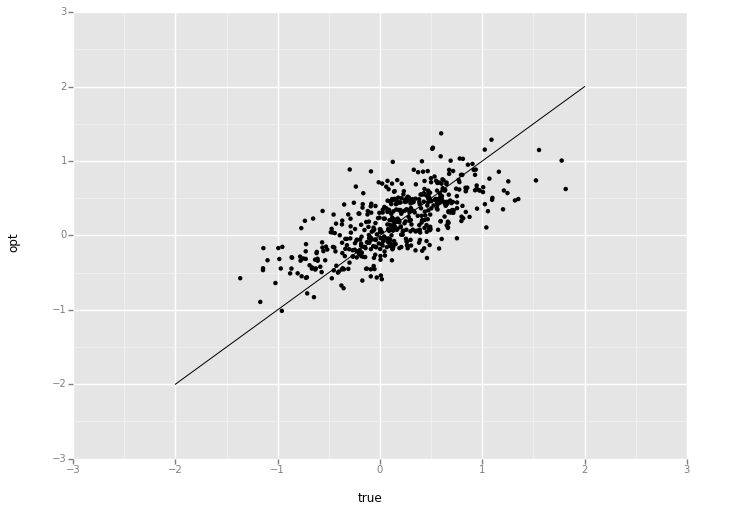

<ggplot: (8756341989685)>

In [55]:
# Check the random effect estimates
from ggplot import *
import pandas as pd
%matplotlib inline

plot_df = pd.DataFrame({ 'opt': glmm_par_opt['u'].mean.get(), 'true': true_u })
ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

In [59]:
print moment_jac.shape
print K

(25, 1354)
25


In [62]:
# LRVB with conjugate gradient
from scipy.sparse.linalg import LinearOperator
import sys

# The we will actually compute Hess^1 * moment_jac.T, leading to perhaps confusing
# naming of "columns".  
moment_jac = MomentJacobian(vb_opt.x)
ObjHessVecProdLO = LinearOperator((vb_opt.x.size, vb_opt.x.size), lambda par: KLHessVecProd(vb_opt.x, par))
# print moment_jac.T.shape
# print ObjHessVecProdLO.shape
# cg_res, info = scipy.sparse.linalg.cg(ObjHessVecProdLO, moment_jac.T)

print moment_jac.shape[0]
lrvb_term = np.full(moment_jac.T.shape, float('nan'))
for col in range(moment_jac.shape[0]):
    sys.stdout.write('.')
    sys.stdout.flush()
    cg_res, info = sp.sparse.linalg.cg(ObjHessVecProdLO, moment_jac[col, :])
    assert info == 0
    lrvb_term[:, col] = cg_res

print 'all done dude'

25
.........................all done dude


In [61]:
# Slow, but maybe faster than using CG.
kl_hess = KLHess(vb_opt.x)

In [68]:
print kl_hess[0,:,:].shape
print moment_jac.shape

beta_cov_hess = np.matmul(moment_jac, np.linalg.solve(kl_hess[0, :, :], moment_jac.T))
beta_cov = np.matmul(moment_jac, lrvb_term)
print np.diag(beta_cov)
print np.diag(beta_cov_hess)
print np.diag(glmm_par_opt['beta'].cov.get())

(1354, 1354)
(25, 1354)
[ 0.00339103  0.00334418  0.00341884  0.00342332  0.00338158  0.00339568
  0.00340015  0.00335606  0.00342186  0.00336915  0.0033738   0.00336496
  0.00333819  0.00336085  0.003367    0.00338254  0.00341238  0.00340509
  0.00338197  0.00341763  0.00338684  0.00334002  0.0033684   0.00341686
  0.00340822]
[ 0.00339103  0.00334418  0.00341884  0.00342332  0.00338158  0.00339568
  0.00340015  0.00335606  0.00342186  0.00336915  0.0033738   0.00336496
  0.00333819  0.00336085  0.003367    0.00338254  0.00341238  0.00340509
  0.00338197  0.00341763  0.00338684  0.00334002  0.0033684   0.00341686
  0.00340822]
[ 0.00842191  0.00831041  0.0084684   0.00848597  0.0083961   0.00841252
  0.00842841  0.00832452  0.00848625  0.00836533  0.00834062  0.00836466
  0.00824275  0.0083402   0.0083433   0.008378    0.00846453  0.00844966
  0.00839679  0.00846756  0.00842281  0.00828866  0.00836042  0.0084983
  0.0084607 ]
